In [1]:
import numpy as np
import cv2
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

from lib import proc_img
from lib import create_gen

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
dir_ = Path('E:/DATASETS/classification/ASL_alphabet/asl_alphabet_train/asl_alphabet_train')
file_paths = list(dir_.glob(r'**/*.jpg'))
print(len(file_paths))

87000


In [3]:
df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

df.head(5) 

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['W' 'E' 'O' 'K' 'N' 'C' 'L' 'del' 'G' 'H' 'U' 'Z' 'Y' 'M' 'nothing' 'P'
 'T' 'R' 'V' 'J' 'A' 'F' 'D' 'X' 'B' 'Q' 'space' 'S' 'I']


,Filepath,Label
0,E:\DATASETS\classification\ASL_alphabet\asl_al...,W
1,E:\DATASETS\classification\ASL_alphabet\asl_al...,E
2,E:\DATASETS\classification\ASL_alphabet\asl_al...,O
3,E:\DATASETS\classification\ASL_alphabet\asl_al...,K
4,E:\DATASETS\classification\ASL_alphabet\asl_al...,N


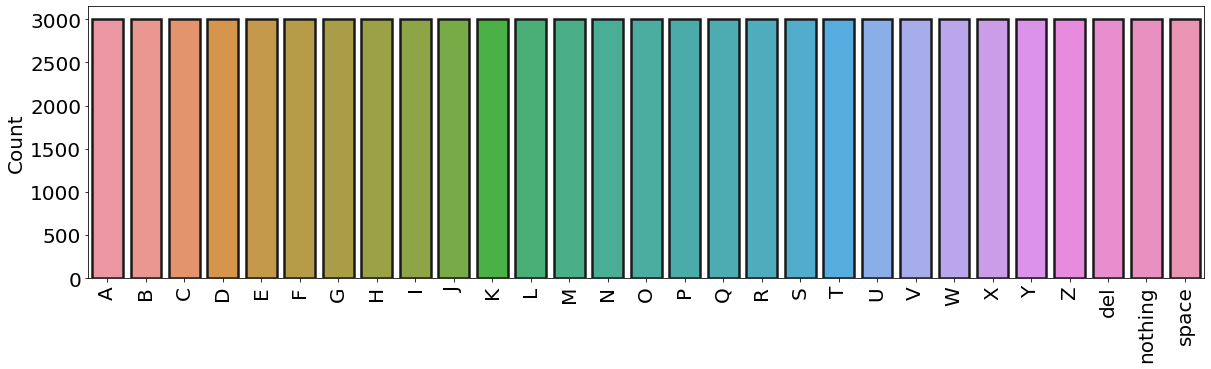

In [4]:
# Display the number of pictures of each category
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, linewidth=2.5, edgecolor=".1")
plt.xticks(rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.show()

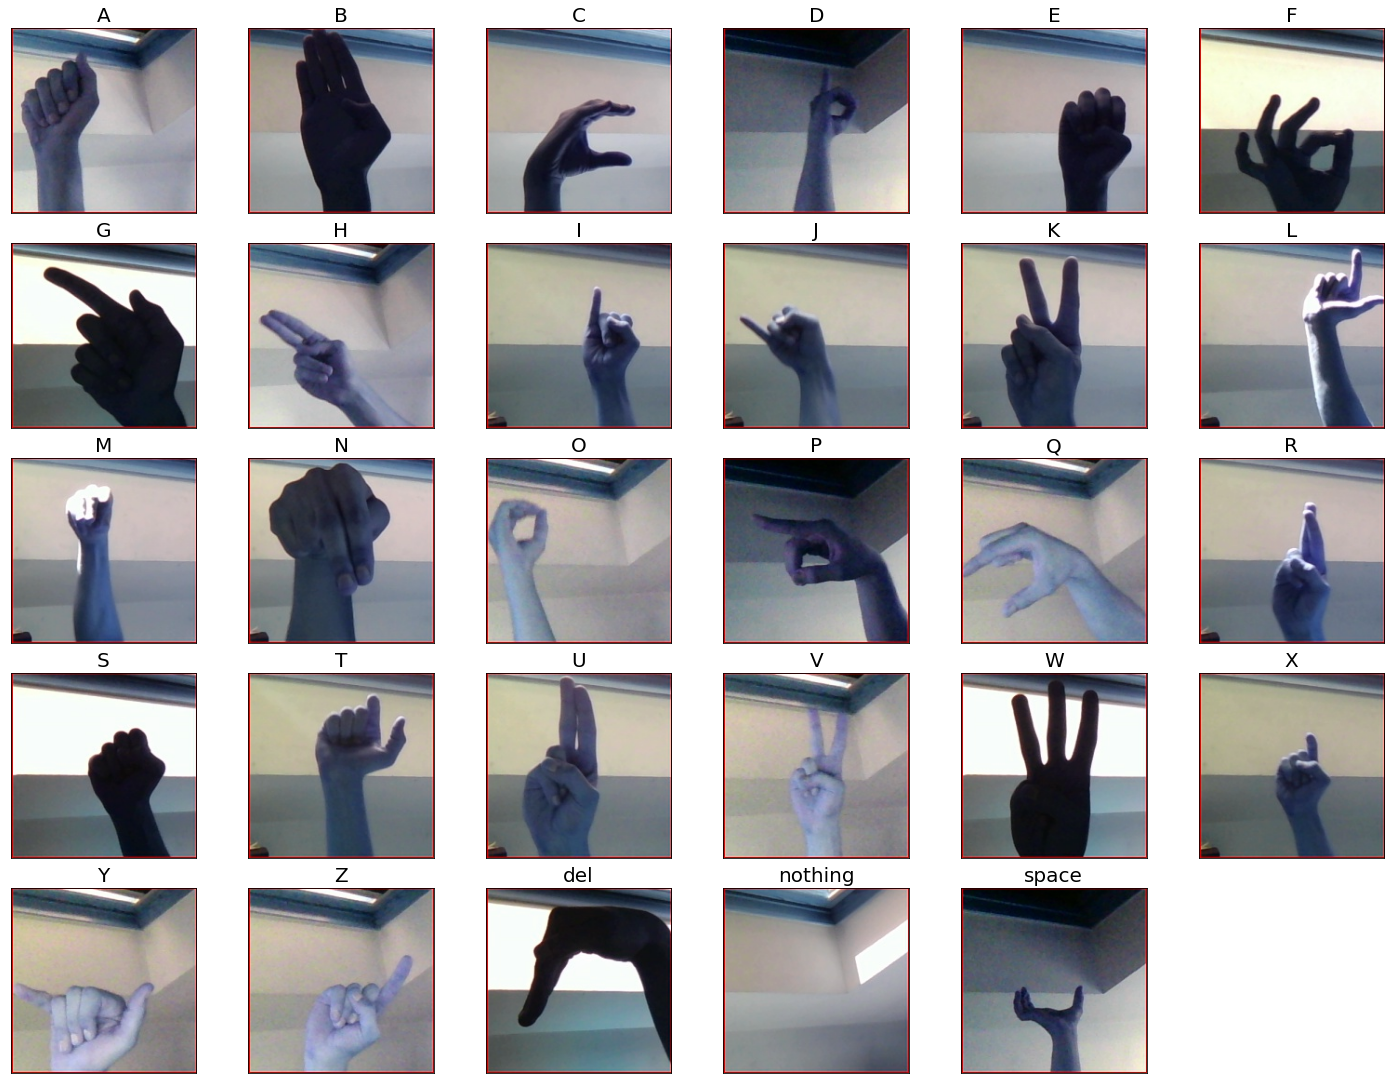

In [5]:
unique_items = df.Label.unique().copy()
unique_items = np.sort(unique_items)

plt.figure(figsize=(20,15))

for i in range(len(unique_items)):
    for j in range(len(df.Label)):
        if df.Label[j] == unique_items[i]:
            plt.subplot(5,6,i+1)
            plt.imshow(cv2.imread(df.Filepath[j]))
            plt.xticks([])
            plt.yticks([])
            plt.title(df.Label[j], fontsize=20)
            i += 1
            break
            
plt.tight_layout(pad=0.5)
plt.show()       

In [6]:
# Use 5% of the dataset for testing various models Split into training and test datasets
train_df, test_df = train_test_split(df.sample(frac = 0.05), test_size=0.2, random_state=0)

In [7]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'max'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    #x = tf.keras.layers.Flatten()(pretrained_model.output)
    
    x = tf.keras.layers.Dense(512, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
                
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}


In [9]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen(train_df, test_df)
print('\n')

Found 3132 validated image filenames belonging to 29 classes.
Found 348 validated image filenames belonging to 29 classes.
Found 870 validated image filenames belonging to 29 classes.






DenseNet121


Epoch 1/30
49/49 [==============================] - 171s 3s/step - loss: 4.0082 - accuracy: 0.0692 - val_loss: 2.1293 - val_accuracy: 0.3534
Epoch 2/30
49/49 [==============================] - 9s 189ms/step - loss: 2.0468 - accuracy: 0.3843 - val_loss: 1.0538 - val_accuracy: 0.6839
Epoch 3/30
49/49 [==============================] - 9s 190ms/step - loss: 1.0386 - accuracy: 0.6686 - val_loss: 0.7014 - val_accuracy: 0.7500
Epoch 4/30
49/49 [==============================] - 10s 194ms/step - loss: 0.7162 - accuracy: 0.7653 - val_loss: 0.4503 - val_accuracy: 0.8563
Epoch 5/30
49/49 [==============================] - 17s 344ms/step - loss: 0.4948 - accuracy: 0.8399 - val_loss: 0.4769 - val_accuracy: 0.8362
Epoch 6/30
49/49 [==============================] - 12s 233ms/step - loss: 0.3997 - accuracy: 0.8626 - val_loss: 0.3782 - val_accuracy: 0.8649
Epoch 7/30
49/49 [==============================] - 9s 192ms/step - loss: 0.3202 - accuracy: 0.8925 - val_loss: 0.3492 - val_accur

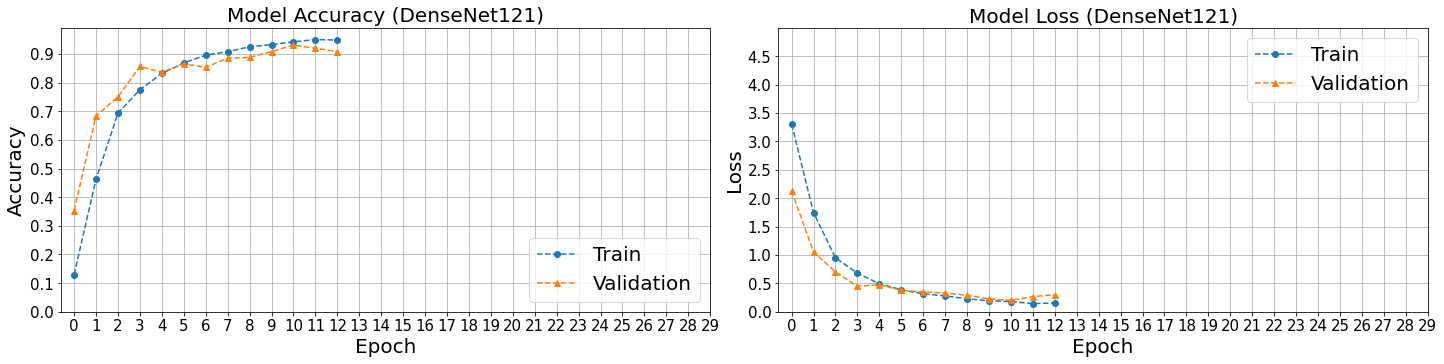

DenseNet121          trained in 300.51 sec
INFO:tensorflow:Assets written to: all_models/DenseNet121\assets


MobileNetV2


Epoch 1/30
49/49 [==============================] - 10s 122ms/step - loss: 5.1658 - accuracy: 0.0543 - val_loss: 2.7880 - val_accuracy: 0.3362
Epoch 2/30
49/49 [==============================] - 4s 85ms/step - loss: 2.5579 - accuracy: 0.2704 - val_loss: 1.4291 - val_accuracy: 0.6207
Epoch 3/30
49/49 [==============================] - 4s 91ms/step - loss: 1.4228 - accuracy: 0.5478 - val_loss: 0.8937 - val_accuracy: 0.7672
Epoch 4/30
49/49 [==============================] - 4s 88ms/step - loss: 0.9042 - accuracy: 0.7031 - val_loss: 0.6367 - val_accuracy: 0.8103
Epoch 5/30
49/49 [==============================] - 4s 89ms/step - loss: 0.6595 - accuracy: 0.7723 - val_loss: 0.5601 - val_accuracy: 0.8190
Epoch 6/30
49/49 [==============================] - 4s 90ms/step - loss: 0.5136 - accuracy: 0.8303 - val_loss: 0.5493 - val_accuracy: 0.8132
Epoch 7/30
49/49 [==========

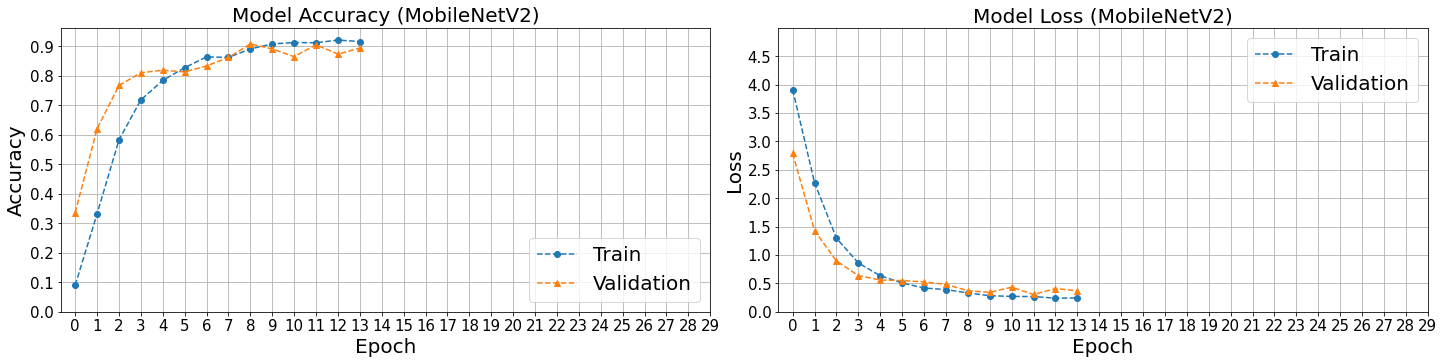

MobileNetV2          trained in 69.59 sec
INFO:tensorflow:Assets written to: all_models/MobileNetV2\assets


DenseNet169


Epoch 1/30
49/49 [==============================] - 26s 328ms/step - loss: 4.0681 - accuracy: 0.0814 - val_loss: 2.1008 - val_accuracy: 0.4282
Epoch 2/30
49/49 [==============================] - 12s 237ms/step - loss: 1.9745 - accuracy: 0.4173 - val_loss: 0.9755 - val_accuracy: 0.7471
Epoch 3/30
49/49 [==============================] - 12s 238ms/step - loss: 0.9653 - accuracy: 0.6966 - val_loss: 0.5721 - val_accuracy: 0.8161
Epoch 4/30
49/49 [==============================] - 12s 238ms/step - loss: 0.5782 - accuracy: 0.8156 - val_loss: 0.4455 - val_accuracy: 0.8592
Epoch 5/30
49/49 [==============================] - 12s 238ms/step - loss: 0.4534 - accuracy: 0.8499 - val_loss: 0.3863 - val_accuracy: 0.8851
Epoch 6/30
49/49 [==============================] - 12s 238ms/step - loss: 0.3161 - accuracy: 0.8987 - val_loss: 0.3201 - val_accuracy: 0.9023
Epoch 7/30
49/49 [=

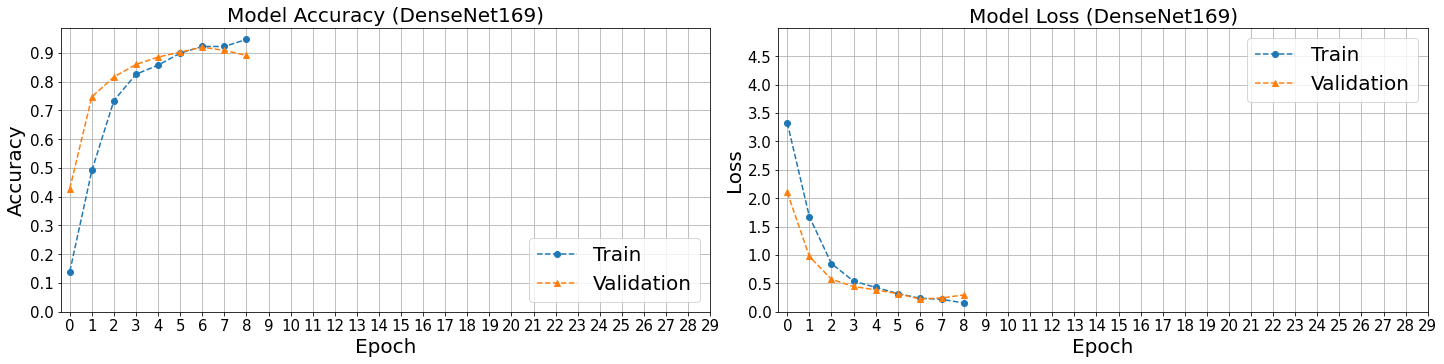

DenseNet169          trained in 121.4 sec
INFO:tensorflow:Assets written to: all_models/DenseNet169\assets


DenseNet201


Epoch 1/30
49/49 [==============================] - 31s 404ms/step - loss: 3.5858 - accuracy: 0.1048 - val_loss: 1.7214 - val_accuracy: 0.4828
Epoch 2/30
49/49 [==============================] - 15s 296ms/step - loss: 1.5540 - accuracy: 0.5221 - val_loss: 0.6825 - val_accuracy: 0.8017
Epoch 3/30
49/49 [==============================] - 15s 298ms/step - loss: 0.7400 - accuracy: 0.7636 - val_loss: 0.5248 - val_accuracy: 0.8247
Epoch 4/30
49/49 [==============================] - 15s 300ms/step - loss: 0.4710 - accuracy: 0.8517 - val_loss: 0.4248 - val_accuracy: 0.8621
Epoch 5/30
49/49 [==============================] - 15s 300ms/step - loss: 0.3545 - accuracy: 0.8812 - val_loss: 0.2619 - val_accuracy: 0.9224
Epoch 6/30
49/49 [==============================] - 15s 301ms/step - loss: 0.2646 - accuracy: 0.9117 - val_loss: 0.3093 - val_accuracy: 0.8994
Epoch 7/30
49/49 [=

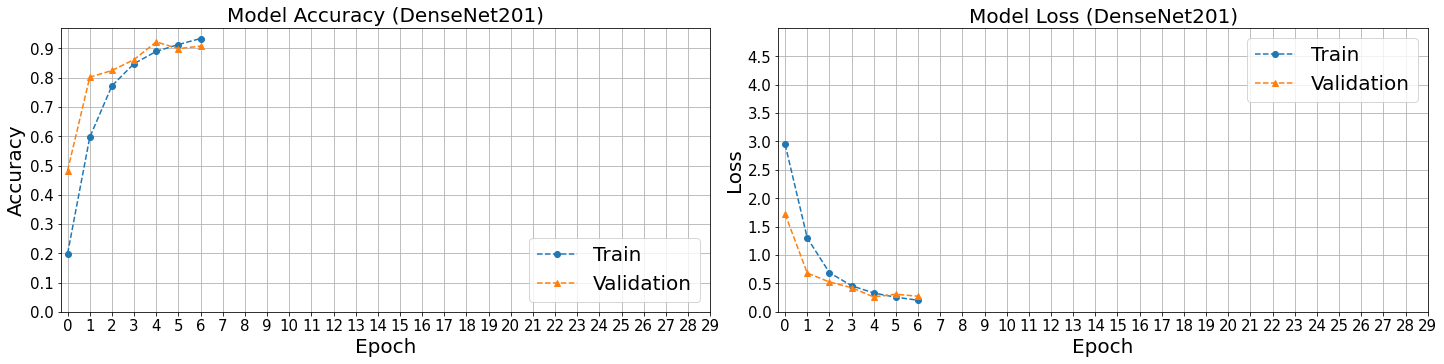

DenseNet201          trained in 120.57 sec
INFO:tensorflow:Assets written to: all_models/DenseNet201\assets


EfficientNetB0


Epoch 1/30
49/49 [==============================] - 14s 170ms/step - loss: 5.0788 - accuracy: 0.0319 - val_loss: 3.3677 - val_accuracy: 0.0201
Epoch 2/30
49/49 [==============================] - 6s 123ms/step - loss: 3.3930 - accuracy: 0.0331 - val_loss: 3.3676 - val_accuracy: 0.0460
Epoch 3/30
49/49 [==============================] - 6s 122ms/step - loss: 3.3766 - accuracy: 0.0416 - val_loss: 3.3679 - val_accuracy: 0.0374
Epoch 4/30
49/49 [==============================] - 6s 123ms/step - loss: 3.3684 - accuracy: 0.0395 - val_loss: 3.3682 - val_accuracy: 0.0374
Epoch 00004: early stopping


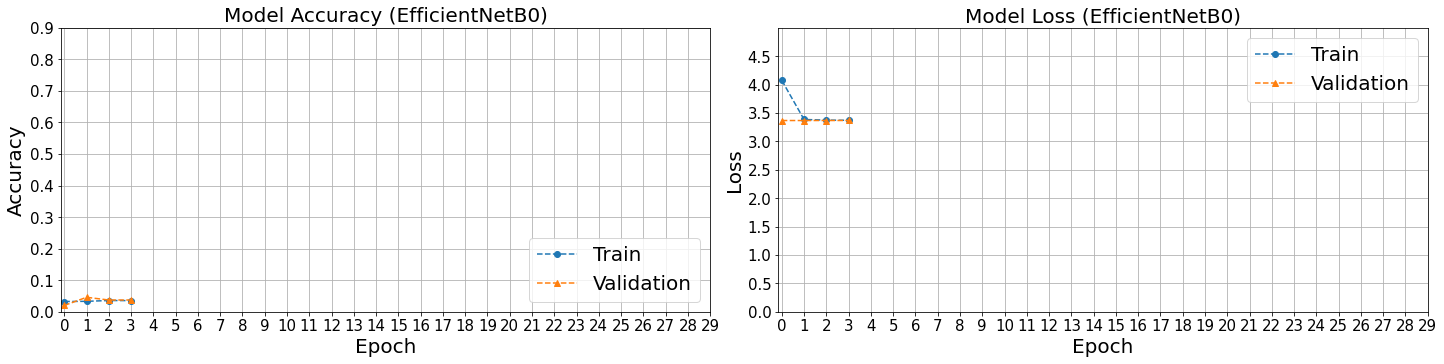

EfficientNetB0       trained in 33.43 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB0\assets


EfficientNetB1


Epoch 1/30
49/49 [==============================] - 18s 217ms/step - loss: 6.0104 - accuracy: 0.0372 - val_loss: 3.3678 - val_accuracy: 0.0230
Epoch 2/30
49/49 [==============================] - 8s 167ms/step - loss: 3.3971 - accuracy: 0.0392 - val_loss: 3.3678 - val_accuracy: 0.0374
Epoch 3/30
49/49 [==============================] - 8s 167ms/step - loss: 3.3765 - accuracy: 0.0436 - val_loss: 3.3665 - val_accuracy: 0.0374
Epoch 4/30
49/49 [==============================] - 8s 167ms/step - loss: 3.3756 - accuracy: 0.0378 - val_loss: 3.3675 - val_accuracy: 0.0201
Epoch 5/30
49/49 [==============================] - 8s 168ms/step - loss: 3.3700 - accuracy: 0.0294 - val_loss: 3.3679 - val_accuracy: 0.0201
Epoch 00005: early stopping


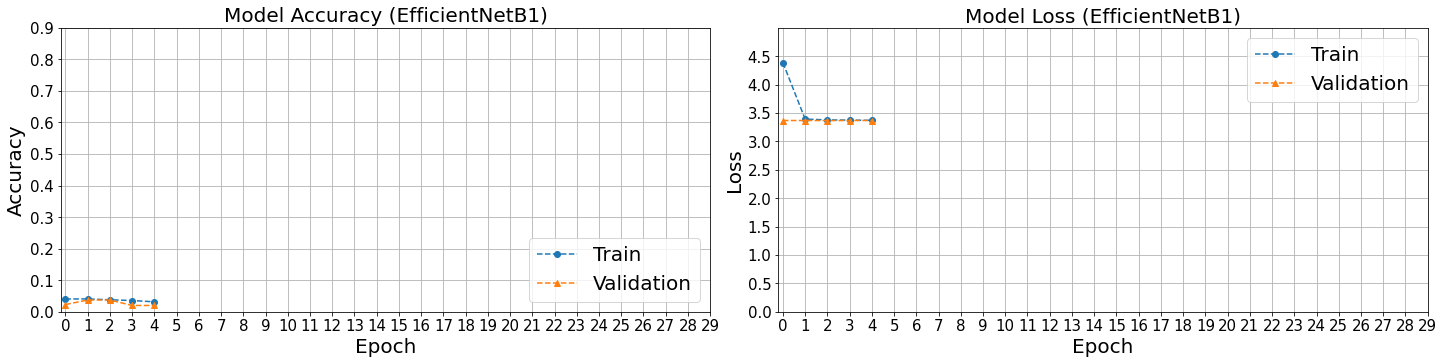

EfficientNetB1       trained in 52.53 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB1\assets


EfficientNetB2


Epoch 1/30
49/49 [==============================] - 20s 241ms/step - loss: 9.1362 - accuracy: 0.0301 - val_loss: 3.3892 - val_accuracy: 0.0287
Epoch 2/30
49/49 [==============================] - 9s 174ms/step - loss: 3.4102 - accuracy: 0.0290 - val_loss: 3.3784 - val_accuracy: 0.0374
Epoch 3/30
49/49 [==============================] - 9s 176ms/step - loss: 3.3843 - accuracy: 0.0299 - val_loss: 3.3674 - val_accuracy: 0.0201
Epoch 4/30
49/49 [==============================] - 9s 177ms/step - loss: 3.3785 - accuracy: 0.0389 - val_loss: 3.3671 - val_accuracy: 0.0316
Epoch 5/30
49/49 [==============================] - 9s 177ms/step - loss: 3.3747 - accuracy: 0.0313 - val_loss: 3.3726 - val_accuracy: 0.0201
Epoch 6/30
49/49 [==============================] - 9s 176ms/step - loss: 3.3682 - accuracy: 0.0396 - val_loss: 3.4319 - val_accuracy: 0.0374
Epoch 00006: early

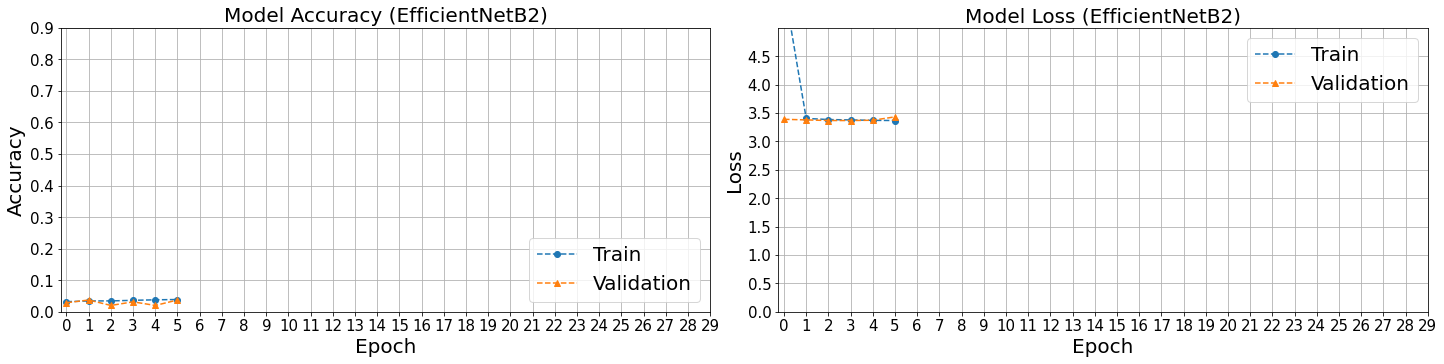

EfficientNetB2       trained in 64.67 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB2\assets


EfficientNetB3


Epoch 1/30
49/49 [==============================] - 28s 312ms/step - loss: 4.0483 - accuracy: 0.0340 - val_loss: 3.3753 - val_accuracy: 0.0374
Epoch 2/30
49/49 [==============================] - 11s 225ms/step - loss: 3.3858 - accuracy: 0.0345 - val_loss: 3.3677 - val_accuracy: 0.0259
Epoch 3/30
49/49 [==============================] - 11s 225ms/step - loss: 3.3751 - accuracy: 0.0387 - val_loss: 3.3682 - val_accuracy: 0.0259
Epoch 4/30
49/49 [==============================] - 11s 227ms/step - loss: 3.3700 - accuracy: 0.0367 - val_loss: 3.3673 - val_accuracy: 0.0402
Epoch 5/30
49/49 [==============================] - 11s 227ms/step - loss: 3.3716 - accuracy: 0.0351 - val_loss: 3.3685 - val_accuracy: 0.0259
Epoch 6/30
49/49 [==============================] - 11s 227ms/step - loss: 3.3712 - accuracy: 0.0380 - val_loss: 3.3689 - val_accuracy: 0.0201
Epoch 00006: 

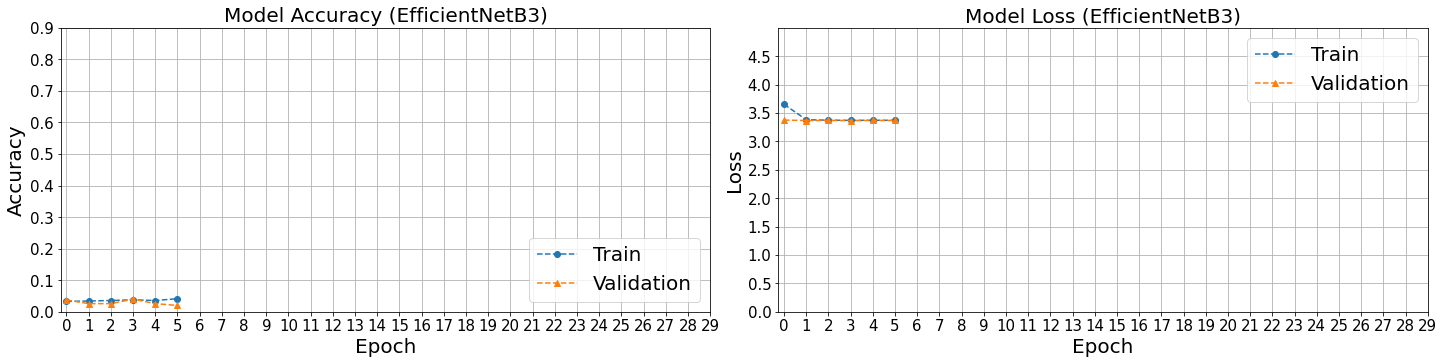

EfficientNetB3       trained in 84.56 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB3\assets


EfficientNetB4


Epoch 1/30
49/49 [==============================] - 30s 391ms/step - loss: 5.2119 - accuracy: 0.0364 - val_loss: 3.3778 - val_accuracy: 0.0374
Epoch 2/30
49/49 [==============================] - 15s 299ms/step - loss: 3.3881 - accuracy: 0.0326 - val_loss: 3.3685 - val_accuracy: 0.0345
Epoch 3/30
49/49 [==============================] - 15s 300ms/step - loss: 3.3686 - accuracy: 0.0317 - val_loss: 3.3689 - val_accuracy: 0.0345
Epoch 4/30
49/49 [==============================] - 15s 302ms/step - loss: 3.3671 - accuracy: 0.0393 - val_loss: 3.3693 - val_accuracy: 0.0201
Epoch 00004: early stopping


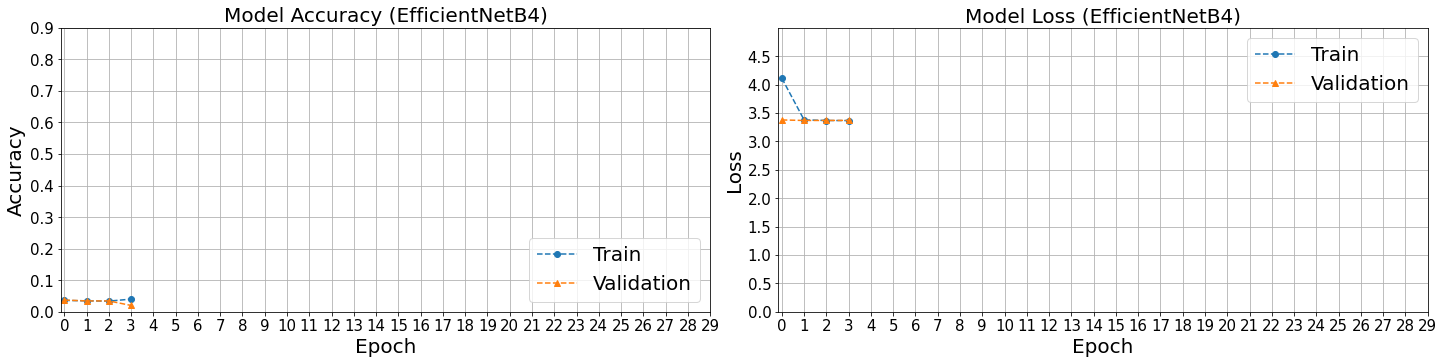

EfficientNetB4       trained in 75.95 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB4\assets


EfficientNetB5


Epoch 1/30
49/49 [==============================] - 28s 356ms/step - loss: 5.4933 - accuracy: 0.0280 - val_loss: 3.3820 - val_accuracy: 0.0489
Epoch 2/30
49/49 [==============================] - 16s 324ms/step - loss: 3.3874 - accuracy: 0.0364 - val_loss: 3.3694 - val_accuracy: 0.0374
Epoch 3/30
49/49 [==============================] - 15s 300ms/step - loss: 3.3835 - accuracy: 0.0287 - val_loss: 3.3716 - val_accuracy: 0.0374
Epoch 4/30
49/49 [==============================] - 15s 301ms/step - loss: 3.3788 - accuracy: 0.0325 - val_loss: 3.3749 - val_accuracy: 0.0201
Epoch 00004: early stopping


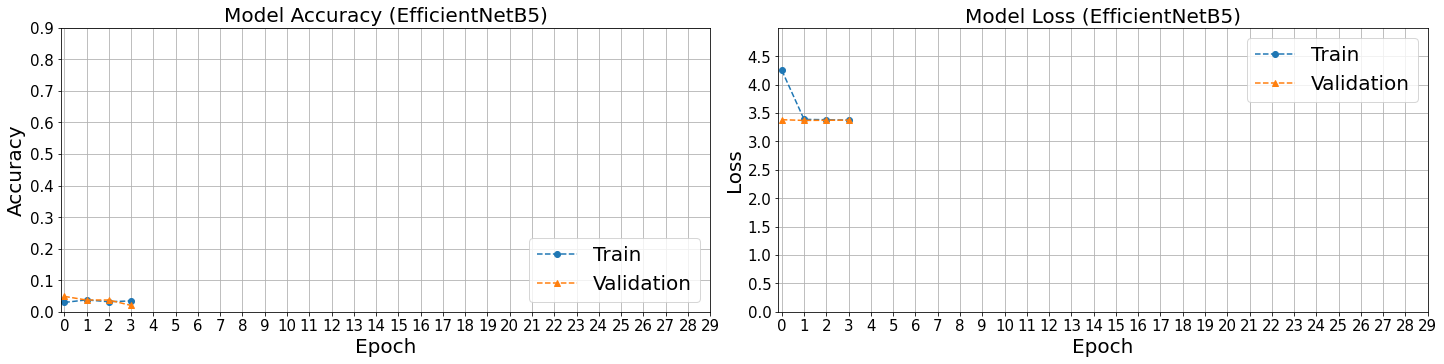

EfficientNetB5       trained in 74.4 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB5\assets


EfficientNetB6


Epoch 1/30
49/49 [==============================] - 28s 355ms/step - loss: 5.7523 - accuracy: 0.0315 - val_loss: 3.3697 - val_accuracy: 0.0374
Epoch 2/30
49/49 [==============================] - 15s 299ms/step - loss: 3.4100 - accuracy: 0.0337 - val_loss: 3.3672 - val_accuracy: 0.0345
Epoch 3/30
49/49 [==============================] - 15s 300ms/step - loss: 3.3814 - accuracy: 0.0429 - val_loss: 3.3676 - val_accuracy: 0.0374
Epoch 4/30
49/49 [==============================] - 15s 301ms/step - loss: 3.3723 - accuracy: 0.0398 - val_loss: 3.3679 - val_accuracy: 0.0201
Epoch 00004: early stopping


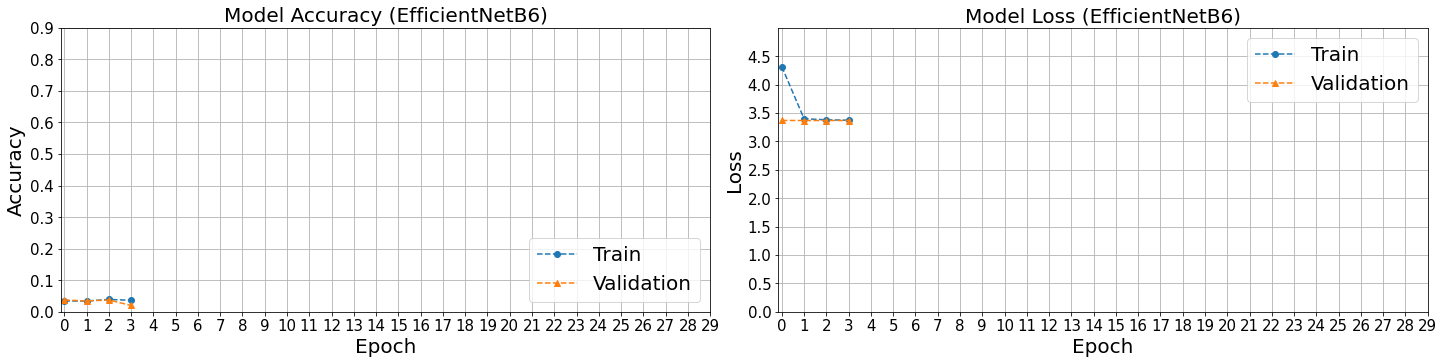

EfficientNetB6       trained in 73.07 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB6\assets


EfficientNetB7


Epoch 1/30
49/49 [==============================] - 28s 354ms/step - loss: 5.4692 - accuracy: 0.0331 - val_loss: 3.3671 - val_accuracy: 0.0402
Epoch 2/30
49/49 [==============================] - 15s 299ms/step - loss: 3.3861 - accuracy: 0.0340 - val_loss: 3.3675 - val_accuracy: 0.0402
Epoch 3/30
49/49 [==============================] - 15s 299ms/step - loss: 3.3769 - accuracy: 0.0387 - val_loss: 3.3680 - val_accuracy: 0.0201
Epoch 00003: early stopping


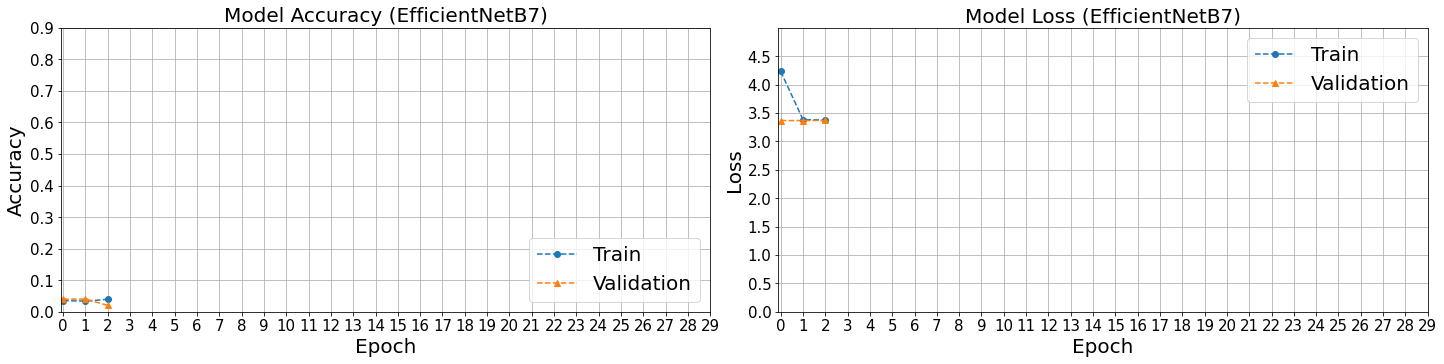

EfficientNetB7       trained in 58.12 sec
INFO:tensorflow:Assets written to: all_models/EfficientNetB7\assets


InceptionResNetV2


Epoch 1/30
49/49 [==============================] - 35s 471ms/step - loss: 4.4230 - accuracy: 0.0570 - val_loss: 3.0895 - val_accuracy: 0.1494
Epoch 2/30
49/49 [==============================] - 17s 344ms/step - loss: 2.9272 - accuracy: 0.1898 - val_loss: 2.3605 - val_accuracy: 0.3075
Epoch 3/30
49/49 [==============================] - 17s 345ms/step - loss: 2.2634 - accuracy: 0.3162 - val_loss: 1.7759 - val_accuracy: 0.4684
Epoch 4/30
49/49 [==============================] - 17s 348ms/step - loss: 1.8141 - accuracy: 0.4197 - val_loss: 1.3865 - val_accuracy: 0.5517
Epoch 5/30
49/49 [==============================] - 17s 348ms/step - loss: 1.4427 - accuracy: 0.5200 - val_loss: 1.3452 - val_accuracy: 0.5862
Epoch 6/30
49/49 [==============================] - 17s 350ms/step - loss: 1.3356 - accuracy: 0.5538 - val_loss: 1.0022 - val_accuracy: 0.6868
Epoch 7/30

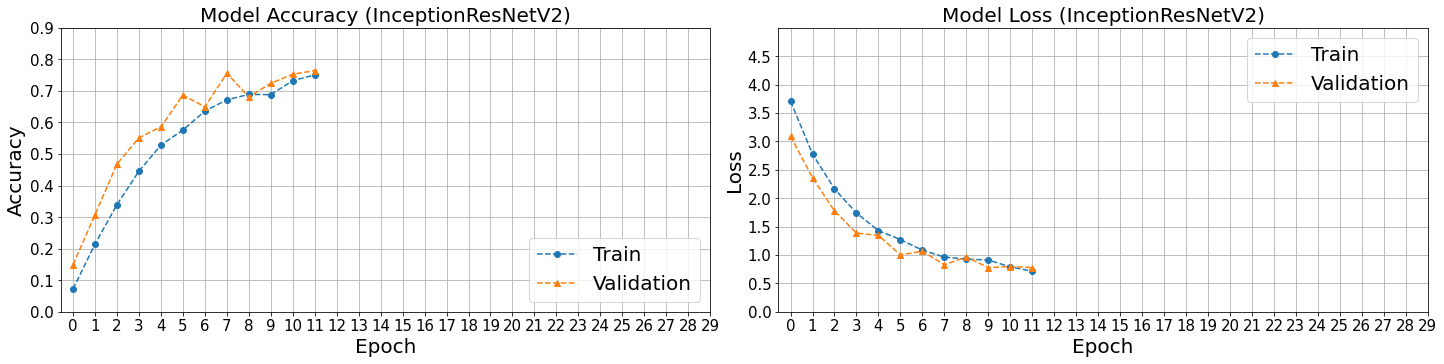

InceptionResNetV2    trained in 225.23 sec
INFO:tensorflow:Assets written to: all_models/InceptionResNetV2\assets


InceptionV3


Epoch 1/30
49/49 [==============================] - 16s 210ms/step - loss: 4.2264 - accuracy: 0.0658 - val_loss: 2.8500 - val_accuracy: 0.2500
Epoch 2/30
49/49 [==============================] - 7s 143ms/step - loss: 2.6376 - accuracy: 0.2507 - val_loss: 1.8884 - val_accuracy: 0.4598
Epoch 3/30
49/49 [==============================] - 7s 143ms/step - loss: 1.8075 - accuracy: 0.4533 - val_loss: 1.3645 - val_accuracy: 0.5948
Epoch 4/30
49/49 [==============================] - 7s 143ms/step - loss: 1.3638 - accuracy: 0.5604 - val_loss: 0.9910 - val_accuracy: 0.7040
Epoch 5/30
49/49 [==============================] - 7s 144ms/step - loss: 1.0082 - accuracy: 0.6662 - val_loss: 0.8557 - val_accuracy: 0.7414
Epoch 6/30
49/49 [==============================] - 7s 144ms/step - loss: 0.8774 - accuracy: 0.7075 - val_loss: 0.7208 - val_accuracy: 0.7759
Epoch 7/30
49/49 

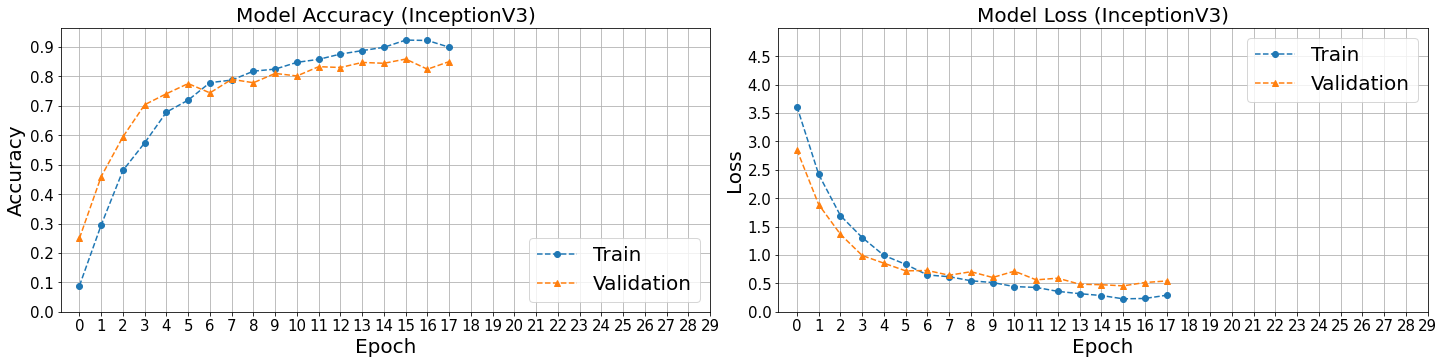

InceptionV3          trained in 138.95 sec
INFO:tensorflow:Assets written to: all_models/InceptionV3\assets


MobileNet


Epoch 1/30
49/49 [==============================] - 9s 141ms/step - loss: 4.4367 - accuracy: 0.0592 - val_loss: 2.6374 - val_accuracy: 0.2672
Epoch 2/30
49/49 [==============================] - 6s 117ms/step - loss: 2.4015 - accuracy: 0.2890 - val_loss: 1.2727 - val_accuracy: 0.5833
Epoch 3/30
49/49 [==============================] - 6s 128ms/step - loss: 1.2828 - accuracy: 0.5846 - val_loss: 0.6425 - val_accuracy: 0.7874
Epoch 4/30
49/49 [==============================] - 6s 127ms/step - loss: 0.7185 - accuracy: 0.7629 - val_loss: 0.4147 - val_accuracy: 0.8448
Epoch 5/30
49/49 [==============================] - 6s 129ms/step - loss: 0.4427 - accuracy: 0.8471 - val_loss: 0.3220 - val_accuracy: 0.9023
Epoch 6/30
49/49 [==============================] - 6s 130ms/step - loss: 0.3311 - accuracy: 0.8856 - val_loss: 0.3335 - val_accuracy: 0.8851
Epoch 7/30
49/49 [========

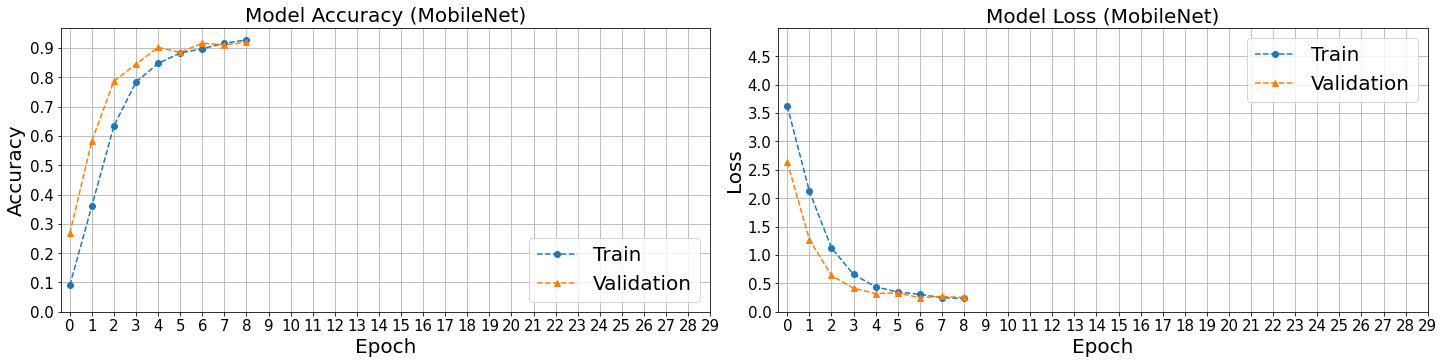

MobileNet            trained in 60.33 sec
INFO:tensorflow:Assets written to: all_models/MobileNet\assets


MobileNetV3Large


Epoch 1/30
49/49 [==============================] - 13s 169ms/step - loss: 3.5054 - accuracy: 0.0406 - val_loss: 3.3742 - val_accuracy: 0.0374
Epoch 2/30
49/49 [==============================] - 6s 131ms/step - loss: 3.3779 - accuracy: 0.0354 - val_loss: 3.3704 - val_accuracy: 0.0259
Epoch 3/30
49/49 [==============================] - 7s 132ms/step - loss: 3.3751 - accuracy: 0.0357 - val_loss: 3.3701 - val_accuracy: 0.0460
Epoch 4/30
49/49 [==============================] - 7s 132ms/step - loss: 3.3699 - accuracy: 0.0340 - val_loss: 3.3697 - val_accuracy: 0.0374
Epoch 5/30
49/49 [==============================] - 7s 133ms/step - loss: 3.3674 - accuracy: 0.0401 - val_loss: 3.3662 - val_accuracy: 0.0489
Epoch 6/30
49/49 [==============================] - 6s 131ms/step - loss: 3.3656 - accuracy: 0.0337 - val_loss: 3.3731 - val_accuracy: 0.0287
Epoch 7/30
49/49 [===

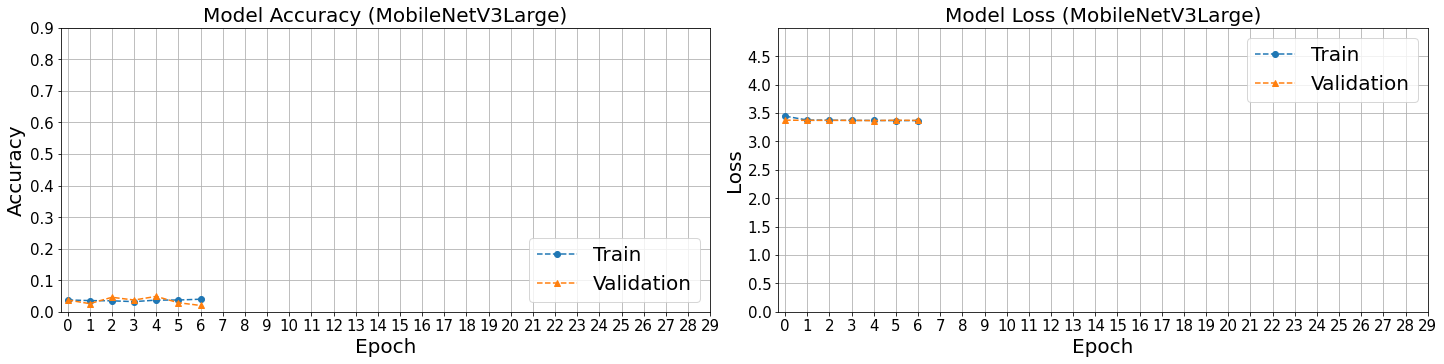

MobileNetV3Large     trained in 53.02 sec
INFO:tensorflow:Assets written to: all_models/MobileNetV3Large\assets


MobileNetV3Small


Epoch 1/30
49/49 [==============================] - 11s 154ms/step - loss: 3.4889 - accuracy: 0.0326 - val_loss: 3.3754 - val_accuracy: 0.0402
Epoch 2/30
49/49 [==============================] - 6s 123ms/step - loss: 3.3797 - accuracy: 0.0362 - val_loss: 3.3722 - val_accuracy: 0.0374
Epoch 3/30
49/49 [==============================] - 6s 127ms/step - loss: 3.3746 - accuracy: 0.0365 - val_loss: 3.3781 - val_accuracy: 0.0316
Epoch 4/30
49/49 [==============================] - 6s 127ms/step - loss: 3.3714 - accuracy: 0.0370 - val_loss: 3.3694 - val_accuracy: 0.0259
Epoch 5/30
49/49 [==============================] - 6s 129ms/step - loss: 3.3659 - accuracy: 0.0312 - val_loss: 3.3706 - val_accuracy: 0.0374
Epoch 6/30
49/49 [==============================] - 6s 128ms/step - loss: 3.3666 - accuracy: 0.0364 - val_loss: 3.3695 - val_accuracy: 0.0172
Epoch 00006: e

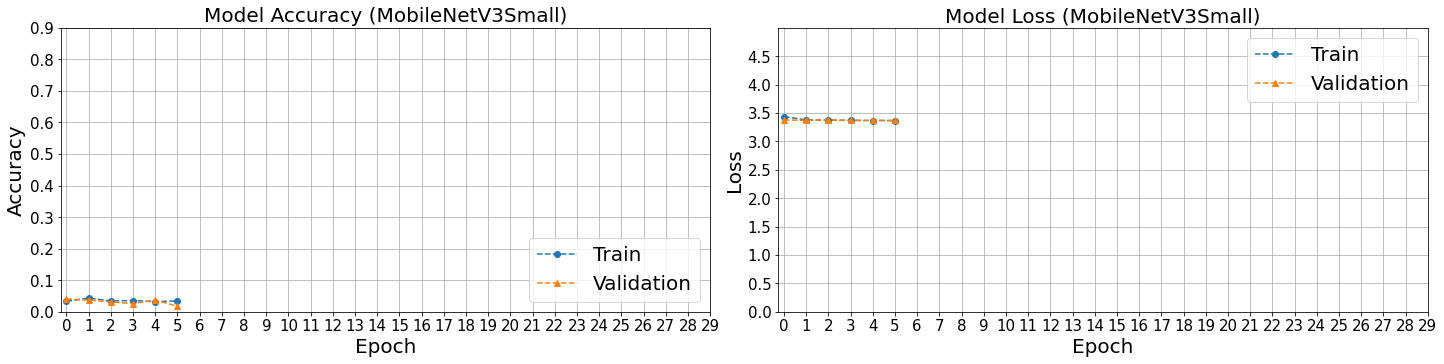

MobileNetV3Small     trained in 43.76 sec
INFO:tensorflow:Assets written to: all_models/MobileNetV3Small\assets


NASNetMobile


Epoch 1/30
49/49 [==============================] - 25s 243ms/step - loss: 3.9338 - accuracy: 0.0655 - val_loss: 2.5838 - val_accuracy: 0.2874
Epoch 2/30
49/49 [==============================] - 7s 149ms/step - loss: 2.4240 - accuracy: 0.3030 - val_loss: 1.6113 - val_accuracy: 0.5287
Epoch 3/30
49/49 [==============================] - 7s 150ms/step - loss: 1.5456 - accuracy: 0.5308 - val_loss: 1.1257 - val_accuracy: 0.6724
Epoch 4/30
49/49 [==============================] - 7s 151ms/step - loss: 1.0789 - accuracy: 0.6503 - val_loss: 1.0013 - val_accuracy: 0.6954
Epoch 5/30
49/49 [==============================] - 7s 150ms/step - loss: 0.8540 - accuracy: 0.7149 - val_loss: 0.9452 - val_accuracy: 0.7213
Epoch 6/30
49/49 [==============================] - 7s 151ms/step - loss: 0.7237 - accuracy: 0.7555 - val_loss: 0.8429 - val_accuracy: 0.7586
Epoch 7/30
49/49 [

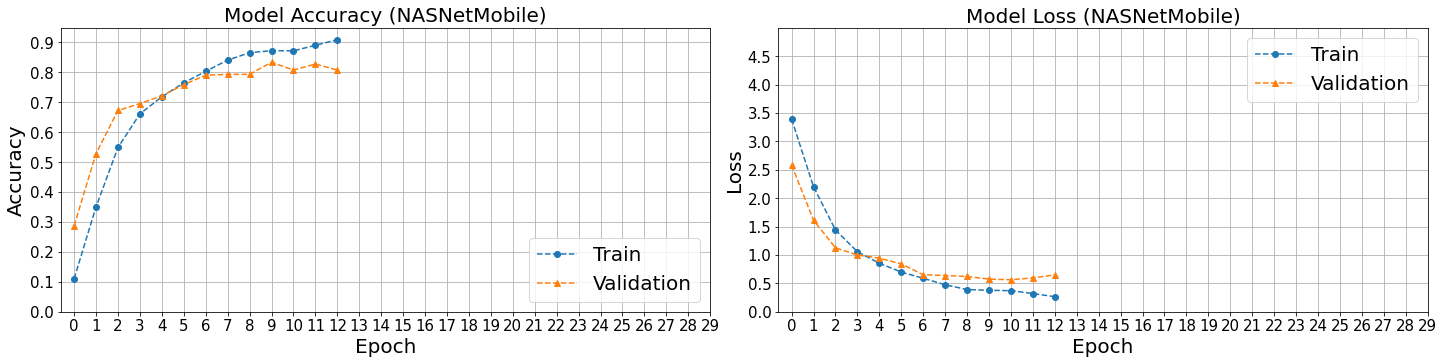

NASNetMobile         trained in 116.12 sec
INFO:tensorflow:Assets written to: all_models/NASNetMobile\assets


ResNet101


Epoch 1/30
49/49 [==============================] - 27s 410ms/step - loss: 3.7929 - accuracy: 0.0470 - val_loss: 3.1088 - val_accuracy: 0.1753
Epoch 2/30
49/49 [==============================] - 17s 338ms/step - loss: 3.0677 - accuracy: 0.1216 - val_loss: 2.7153 - val_accuracy: 0.2155
Epoch 3/30
49/49 [==============================] - 17s 340ms/step - loss: 2.6090 - accuracy: 0.2341 - val_loss: 2.3210 - val_accuracy: 0.3046
Epoch 4/30
49/49 [==============================] - 17s 341ms/step - loss: 2.2184 - accuracy: 0.3267 - val_loss: 2.0437 - val_accuracy: 0.4138
Epoch 5/30
49/49 [==============================] - 17s 343ms/step - loss: 2.0336 - accuracy: 0.3832 - val_loss: 1.8970 - val_accuracy: 0.4052
Epoch 6/30
49/49 [==============================] - 17s 343ms/step - loss: 1.8671 - accuracy: 0.4249 - val_loss: 1.7391 - val_accuracy: 0.4598
Epoch 7/30
49/49 [=

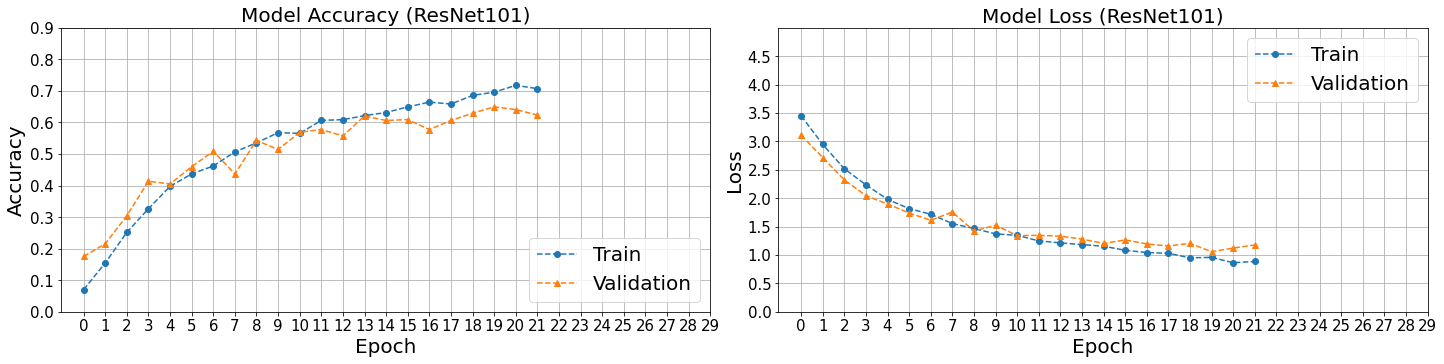

ResNet101            trained in 385.65 sec
INFO:tensorflow:Assets written to: all_models/ResNet101\assets


ResNet101V2


Epoch 1/30
49/49 [==============================] - 26s 408ms/step - loss: 6.6274 - accuracy: 0.1020 - val_loss: 1.8279 - val_accuracy: 0.4224
Epoch 2/30
49/49 [==============================] - 15s 304ms/step - loss: 1.7738 - accuracy: 0.4572 - val_loss: 0.9984 - val_accuracy: 0.6868
Epoch 3/30
49/49 [==============================] - 16s 325ms/step - loss: 0.9710 - accuracy: 0.6878 - val_loss: 0.6251 - val_accuracy: 0.8075
Epoch 4/30
49/49 [==============================] - 16s 318ms/step - loss: 0.6407 - accuracy: 0.7939 - val_loss: 0.5030 - val_accuracy: 0.8333
Epoch 5/30
49/49 [==============================] - 16s 317ms/step - loss: 0.4986 - accuracy: 0.8416 - val_loss: 0.5021 - val_accuracy: 0.8362
Epoch 6/30
49/49 [==============================] - 16s 324ms/step - loss: 0.3815 - accuracy: 0.8735 - val_loss: 0.3934 - val_accuracy: 0.8592
Epoch 7/30
49/49 [==

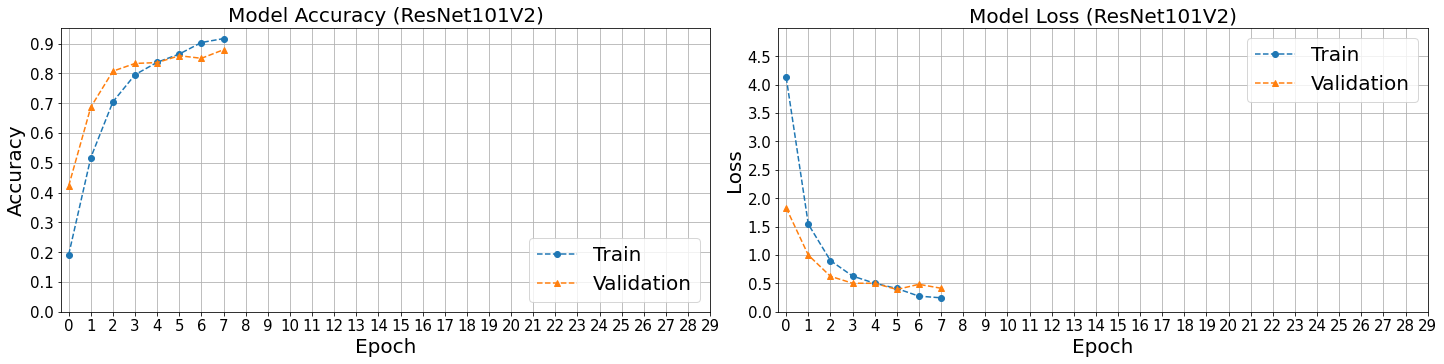

ResNet101V2          trained in 137.24 sec
INFO:tensorflow:Assets written to: all_models/ResNet101V2\assets


ResNet152


Epoch 1/30
49/49 [==============================] - 39s 609ms/step - loss: 3.5838 - accuracy: 0.0575 - val_loss: 3.0040 - val_accuracy: 0.1667
Epoch 2/30
49/49 [==============================] - 24s 493ms/step - loss: 2.9033 - accuracy: 0.1619 - val_loss: 2.3264 - val_accuracy: 0.3218
Epoch 3/30
49/49 [==============================] - 24s 496ms/step - loss: 2.3753 - accuracy: 0.2876 - val_loss: 2.0588 - val_accuracy: 0.3908
Epoch 4/30
49/49 [==============================] - 24s 496ms/step - loss: 2.0624 - accuracy: 0.3701 - val_loss: 1.9389 - val_accuracy: 0.3994
Epoch 5/30
49/49 [==============================] - 25s 500ms/step - loss: 1.7794 - accuracy: 0.4515 - val_loss: 1.6863 - val_accuracy: 0.4684
Epoch 6/30
49/49 [==============================] - 25s 500ms/step - loss: 1.6140 - accuracy: 0.4964 - val_loss: 1.4438 - val_accuracy: 0.5546
Epoch 7/30
49/49 [==

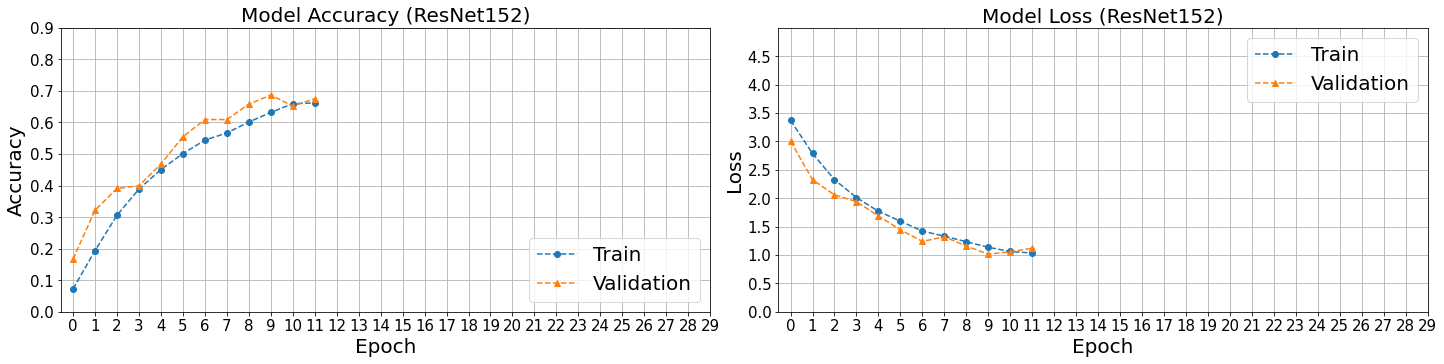

ResNet152            trained in 451.15 sec
INFO:tensorflow:Assets written to: all_models/ResNet152\assets


ResNet152V2


Epoch 1/30
49/49 [==============================] - 91s 2s/step - loss: 5.5170 - accuracy: 0.1011 - val_loss: 1.8496 - val_accuracy: 0.5057
Epoch 2/30
49/49 [==============================] - 21s 436ms/step - loss: 1.8576 - accuracy: 0.4602 - val_loss: 1.0568 - val_accuracy: 0.6782
Epoch 3/30
49/49 [==============================] - 22s 440ms/step - loss: 1.0109 - accuracy: 0.6922 - val_loss: 0.6803 - val_accuracy: 0.7586
Epoch 4/30
49/49 [==============================] - 22s 441ms/step - loss: 0.6533 - accuracy: 0.7739 - val_loss: 0.5918 - val_accuracy: 0.8103
Epoch 5/30
49/49 [==============================] - 22s 442ms/step - loss: 0.4955 - accuracy: 0.8395 - val_loss: 0.6328 - val_accuracy: 0.7902
Epoch 6/30
49/49 [==============================] - 22s 443ms/step - loss: 0.4191 - accuracy: 0.8613 - val_loss: 0.3989 - val_accuracy: 0.8851
Epoch 7/30
49/49 [=====

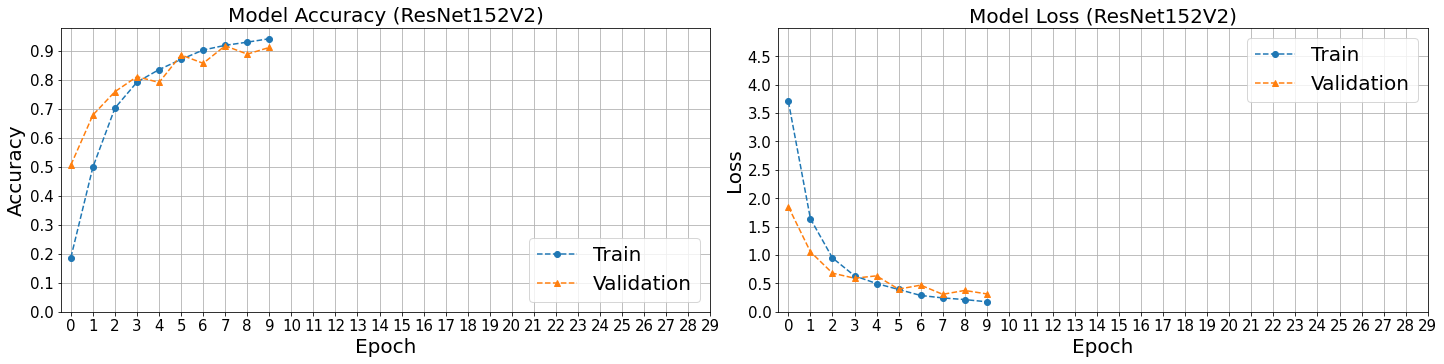

ResNet152V2          trained in 288.89 sec
INFO:tensorflow:Assets written to: all_models/ResNet152V2\assets


ResNet50


Epoch 1/30
49/49 [==============================] - 14s 227ms/step - loss: 3.7581 - accuracy: 0.0587 - val_loss: 3.1229 - val_accuracy: 0.1379
Epoch 2/30
49/49 [==============================] - 10s 205ms/step - loss: 3.0150 - accuracy: 0.1425 - val_loss: 2.6730 - val_accuracy: 0.2069
Epoch 3/30
49/49 [==============================] - 10s 207ms/step - loss: 2.6275 - accuracy: 0.2257 - val_loss: 2.3710 - val_accuracy: 0.2730
Epoch 4/30
49/49 [==============================] - 10s 206ms/step - loss: 2.3717 - accuracy: 0.2730 - val_loss: 2.1743 - val_accuracy: 0.3420
Epoch 5/30
49/49 [==============================] - 10s 206ms/step - loss: 2.1805 - accuracy: 0.3295 - val_loss: 2.0241 - val_accuracy: 0.3966
Epoch 6/30
49/49 [==============================] - 10s 206ms/step - loss: 2.0588 - accuracy: 0.3574 - val_loss: 1.9200 - val_accuracy: 0.4109
Epoch 7/30
49/49 [===

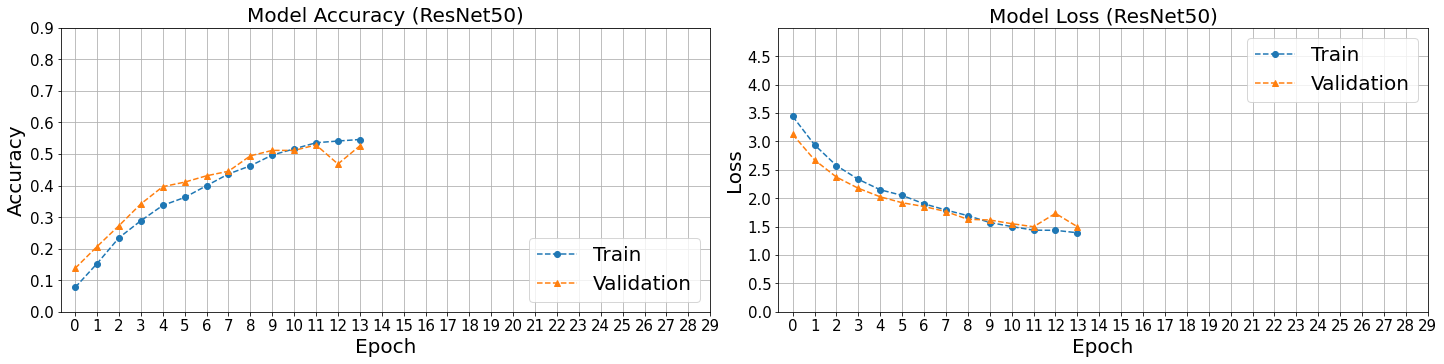

ResNet50             trained in 148.28 sec
INFO:tensorflow:Assets written to: all_models/ResNet50\assets


ResNet50V2


Epoch 1/30
49/49 [==============================] - 13s 196ms/step - loss: 6.1319 - accuracy: 0.1062 - val_loss: 1.9601 - val_accuracy: 0.4195
Epoch 2/30
49/49 [==============================] - 9s 175ms/step - loss: 1.8739 - accuracy: 0.4294 - val_loss: 1.0695 - val_accuracy: 0.6667
Epoch 3/30
49/49 [==============================] - 9s 176ms/step - loss: 1.0334 - accuracy: 0.6773 - val_loss: 0.7247 - val_accuracy: 0.7787
Epoch 4/30
49/49 [==============================] - 9s 176ms/step - loss: 0.6738 - accuracy: 0.7835 - val_loss: 0.4943 - val_accuracy: 0.8592
Epoch 5/30
49/49 [==============================] - 9s 176ms/step - loss: 0.5099 - accuracy: 0.8376 - val_loss: 0.4534 - val_accuracy: 0.8592
Epoch 6/30
49/49 [==============================] - 9s 176ms/step - loss: 0.3771 - accuracy: 0.8743 - val_loss: 0.2948 - val_accuracy: 0.9052
Epoch 7/30
49/49 [=========

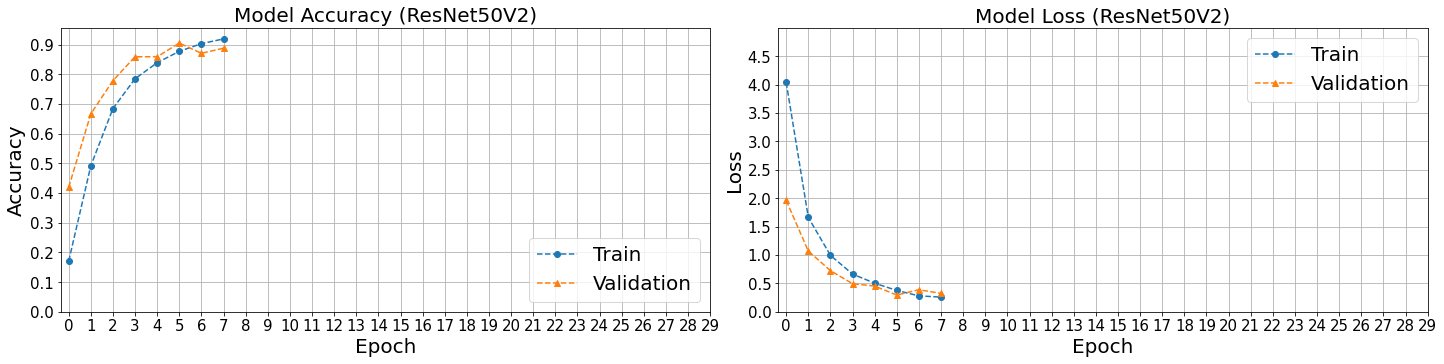

ResNet50V2           trained in 74.97 sec
INFO:tensorflow:Assets written to: all_models/ResNet50V2\assets


VGG16


Epoch 1/30
49/49 [==============================] - 33s 512ms/step - loss: 3.2482 - accuracy: 0.1211 - val_loss: 1.7297 - val_accuracy: 0.5517
Epoch 2/30
49/49 [==============================] - 13s 260ms/step - loss: 1.5429 - accuracy: 0.5340 - val_loss: 0.6985 - val_accuracy: 0.7989
Epoch 3/30
49/49 [==============================] - 13s 260ms/step - loss: 0.7465 - accuracy: 0.7685 - val_loss: 0.4754 - val_accuracy: 0.8592
Epoch 4/30
49/49 [==============================] - 13s 262ms/step - loss: 0.4633 - accuracy: 0.8575 - val_loss: 0.3725 - val_accuracy: 0.8851
Epoch 5/30
49/49 [==============================] - 13s 262ms/step - loss: 0.3509 - accuracy: 0.8903 - val_loss: 0.2938 - val_accuracy: 0.8994
Epoch 6/30
49/49 [==============================] - 13s 262ms/step - loss: 0.2756 - accuracy: 0.9137 - val_loss: 0.1979 - val_accuracy: 0.9339
Epoch 7/30
49/49 [========

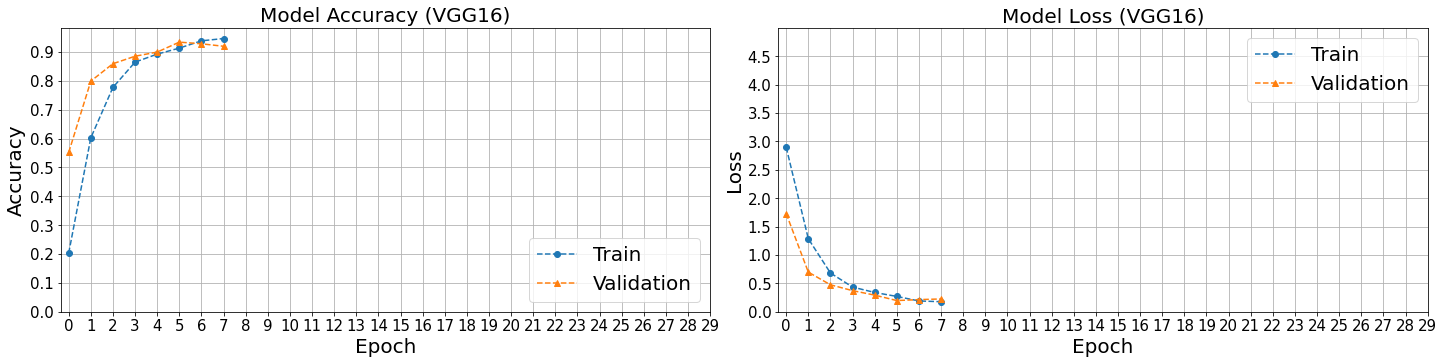

VGG16                trained in 126.24 sec
INFO:tensorflow:Assets written to: all_models/VGG16\assets


VGG19


Epoch 1/30
49/49 [==============================] - 16s 316ms/step - loss: 3.3024 - accuracy: 0.0767 - val_loss: 2.1881 - val_accuracy: 0.4799
Epoch 2/30
49/49 [==============================] - 15s 310ms/step - loss: 1.9776 - accuracy: 0.4434 - val_loss: 1.0964 - val_accuracy: 0.6753
Epoch 3/30
49/49 [==============================] - 15s 311ms/step - loss: 1.0274 - accuracy: 0.6876 - val_loss: 0.7514 - val_accuracy: 0.7816
Epoch 4/30
49/49 [==============================] - 15s 312ms/step - loss: 0.7336 - accuracy: 0.7707 - val_loss: 0.5847 - val_accuracy: 0.8190
Epoch 5/30
49/49 [==============================] - 15s 312ms/step - loss: 0.5423 - accuracy: 0.8285 - val_loss: 0.4563 - val_accuracy: 0.8736
Epoch 6/30
49/49 [==============================] - 15s 313ms/step - loss: 0.3519 - accuracy: 0.8912 - val_loss: 0.3733 - val_accuracy: 0.8851
Epoch 7/30
49/49 [============

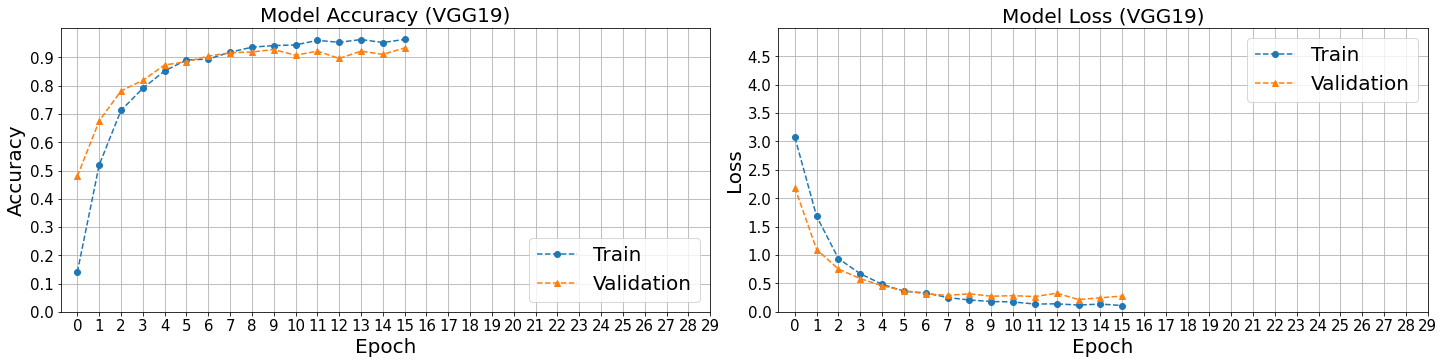

VGG19                trained in 248.87 sec
INFO:tensorflow:Assets written to: all_models/VGG19\assets


Xception


Epoch 1/30
49/49 [==============================] - 20s 330ms/step - loss: 3.1322 - accuracy: 0.1529 - val_loss: 1.5602 - val_accuracy: 0.5086
Epoch 2/30
49/49 [==============================] - 13s 266ms/step - loss: 1.5620 - accuracy: 0.5158 - val_loss: 0.7761 - val_accuracy: 0.7644
Epoch 3/30
49/49 [==============================] - 13s 266ms/step - loss: 0.8268 - accuracy: 0.7361 - val_loss: 0.5356 - val_accuracy: 0.8190
Epoch 4/30
49/49 [==============================] - 13s 267ms/step - loss: 0.5444 - accuracy: 0.8159 - val_loss: 0.4394 - val_accuracy: 0.8563
Epoch 5/30
49/49 [==============================] - 13s 267ms/step - loss: 0.3847 - accuracy: 0.8792 - val_loss: 0.3294 - val_accuracy: 0.8937
Epoch 6/30
49/49 [==============================] - 13s 267ms/step - loss: 0.3022 - accuracy: 0.9045 - val_loss: 0.5295 - val_accuracy: 0.8247
Epoch 7/30
49/49 [=========

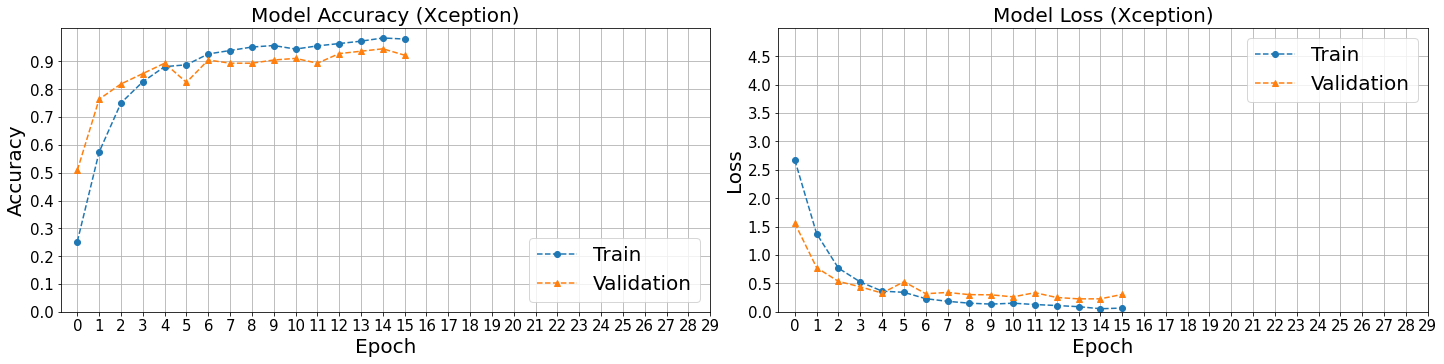

Xception             trained in 219.8 sec
INFO:tensorflow:Assets written to: all_models/Xception\assets


In [10]:
# Fit the models
maxEpochs = 30
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    print(f"\n\n{name}\n\n")
    start = perf_counter()
    
    
    early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=2)
    history = m.fit(train_images,validation_data=val_images, epochs=maxEpochs, verbose=1, callbacks=early_stop)
       
        
    fig = plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    # summarize history for accuracy
    plt.plot(history.history['accuracy'], "--o")
    plt.plot(history.history['val_accuracy'], "--^")
    plt.title(f"Model Accuracy ({name})", fontsize=20)
    plt.xticks(np.arange(0, maxEpochs, 1), fontsize=15) 
    plt.yticks(np.arange(0, 1, 0.1), fontsize=15) 
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.grid(True)
    plt.legend(['Train', 'Validation'], fontsize=20, loc='lower right')

    plt.subplot(1,2,2)
    # summarize history for loss
    plt.plot(history.history['loss'], "--o")
    plt.plot(history.history['val_loss'], "--^")
    plt.title(f"Model Loss ({name})", fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epoch', fontsize=20)
    plt.xticks(np.arange(0, maxEpochs, 1), fontsize=15) 
    plt.yticks(np.arange(0, 5, 0.5), fontsize=15) 
    plt.ylim([0, 5])
    plt.grid(True)
    plt.legend(['Train', 'Validation'], fontsize=20, loc='upper right')
    
    plt.tight_layout(pad=0.5)
    plt.show()
    fig.savefig(f"results/{name}.pdf", dpi = 100)
    plt.close(fig) 
                
    # Fit the model
    # history = m.fit(train_images,validation_data=val_images,epochs=3,verbose=1)
    
    # Sav the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    m.save(f"all_models/{name}")
    

In [11]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,VGG19,0.9339,248.87
1,Xception,0.9224,219.80
2,MobileNet,0.9195,60.33
3,VGG16,0.9195,126.24
4,ResNet152V2,0.9109,288.89
5,DenseNet121,0.9080,300.51
6,DenseNet201,0.9080,120.57
7,MobileNetV2,0.8937,69.59
8,DenseNet169,0.8908,121.40
9,ResNet50V2,0.8879,74.97


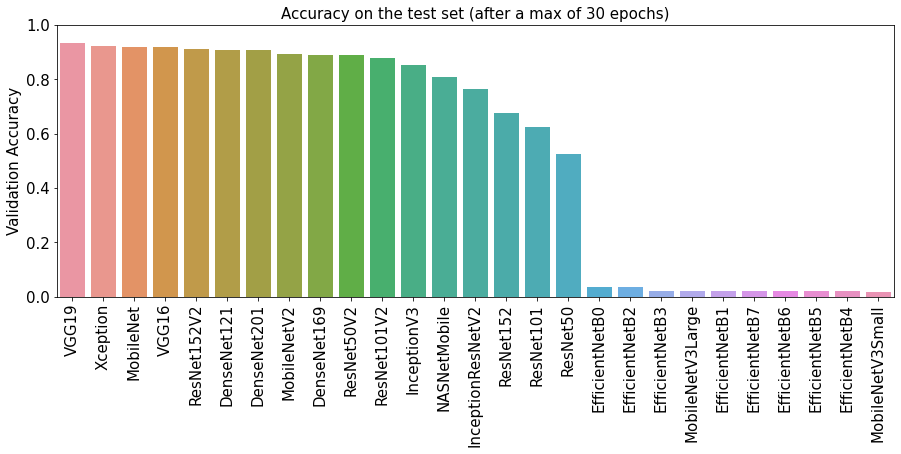

In [29]:

fig = plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after a max of 30 epochs)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Validation Accuracy",fontsize=15)
plt.xlabel("")
plt.show()
fig.savefig(f"results/all_val_acc.jpg", dpi = 100)
plt.close(fig) 

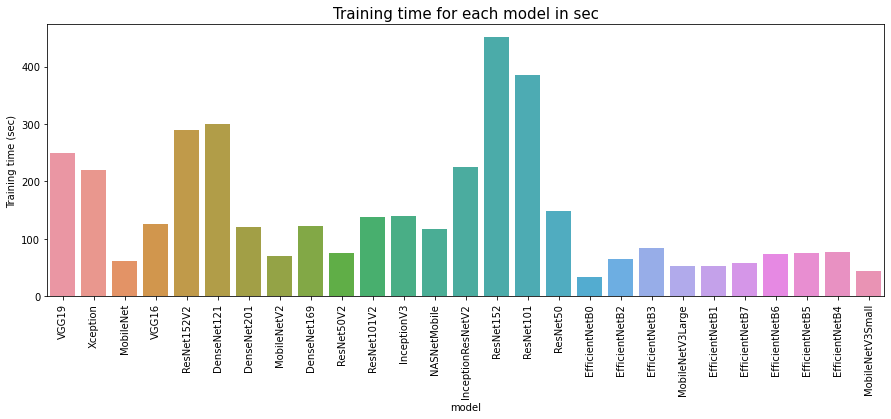

In [13]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()